# Forecasting Financial Securities Trading Volume with an LSTM Neural Network
<a name="toc"></a>

**Estimated time: 30 min**

This notebook will use the example of forecasting the trading volumes of financial securities, to demonstrate the set-up and implementation of an Long-Short Term Memory (LSTM) Neural Net for the purpose of prediction. 

 This content was designed to run from within an [AWS EC2 Deep Learning AMI](https://aws.amazon.com/marketplace/fulfillment?productId=17364a08-2d77-4969-8dbe-d46dcfea4d64&ref_=dtl_psb_continue), of size m5.xlarge. 

In this lab, we will download a real-data set, and format it for digestion by an LSTM. We will then set-up the design of our LSTM net, and train the model with the given data. We use the trained LSTM model to predict the out-of-sample trading volumes, and evaluate this forecast accuracy.


**Prerequisite Instructions:**
1. Spin up a m5.xlarge AWS Deep Learning (DL) AMI.
1. Within your AWS console, navigate to the [EC2 Console](https://console.aws.amazon.com/ec2/v2/home?#Instances:search=reinvent;sort=desc:launchTime), select the DL AMI, and look up its Public IP.
1. In a terminal of your local machine, run `ssh -i <your-pem-key-file> -L 8888:localhost:8888 ubuntu@<public-ip-address>`.
1. Upon ssh-ing your EC2 instance, run `source activate mxnet_p36 && conda install pydot -y`.
1. In the EC2 terminal, run `jupyter-notebook --no-browser --port=8888 && jupyter-notebook list`.
1. The last command will output an http address of jupyter notebook tree with its security token attached. Copy this url and paste it into a chrome browser. This will remotely log you in to the jupyter notebook that is hosted on your EC2.
1. Once you see the jupyter Home tree, click the 'Upload' button on the right-hand side and upload this notebook.
1. Begin executing the cells of this notebook, and follow accompanying instructions.

**Table of Contents:** 

1. [The Data](#data)
1. [Problem Statement](#problemstatement)
1. [Data Pre-processing](#engineering)
    1. [Reshape from a Time Series into Supervised Observations](#supervised)
    1. [Split into Training and Test Sets](#training)
    1. [Format the data for LSTM input](#reshape)
1. [Design the LSTM](#design)
    1. [Fit the LSTM network with the training data](#fit)
1. [Predict the test data](#predict)
    1. [Evaluation the LSTM performance](#evaluate)

# The data <a name="data"></a>

The [Deutsche Börse Public Data Set](https://registry.opendata.aws/deutsche-boerse-pds/) consists of trade data from the Xetra trading system. It provides the initial price, lowest price, highest price, final price and volume of traded securities for every minute of the trading day. This data source has an update frequency of every minute during trading hours.

Here we will read the data from its S3 locations directly into our notebook's memory:

<div style="text-align: right"> [Back to top](#toc) </div>

In [1]:
import time
whole_start = time.time()

In [2]:
import pandas as pd
csvList = ['s3://deutsche-boerse-xetra-pds/2018-10-10/2018-10-10_BINS_XETR13.csv',
           's3://deutsche-boerse-xetra-pds/2018-10-10/2018-10-10_BINS_XETR14.csv',
           's3://deutsche-boerse-xetra-pds/2018-10-10/2018-10-10_BINS_XETR15.csv']

raw = pd.concat([pd.read_csv(f, error_bad_lines=False, warn_bad_lines=False) for f in csvList], ignore_index = True)

dt = raw.iloc[0]['Date']
raw.drop(raw.index[raw['Date']!=dt], inplace=True)
raw['DateTime'] = pd.to_datetime(raw['Date'] + ' ' + raw['Time'])
raw.set_index('DateTime', inplace=True)
raw.head()


ImportError: The s3fs library is required to handle s3 files

## Problem Statement <a name="problemstatement"></a>

We will focus on the univariate series, the column titled `TradedVolume`. This has the total size of trades made for a given security at its point in time. Let's take the trades in the 100 minutes from 13:30 PM -15:10 PM, and see if we can use the first 70 minutes of trades to train a model, that can subsequently predict one-step ahead volumes for the subsequent 30 minutes.

<div style="text-align: right"> [Back to top](#toc) </div>

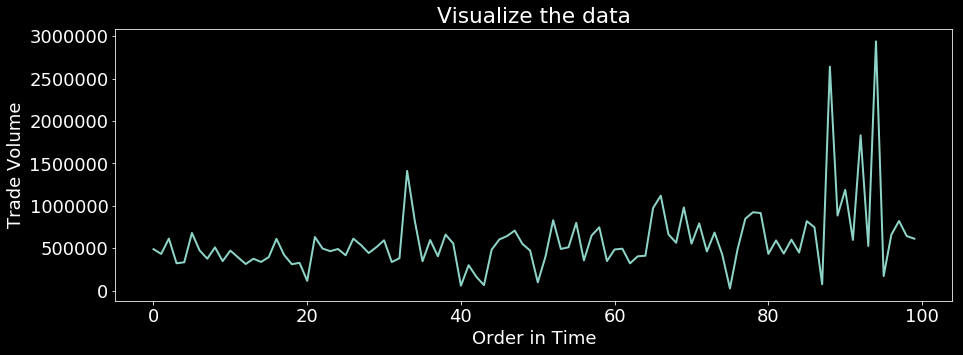

In [3]:
series = raw['TradedVolume'].resample('min').sum()['2018-10-10 13:30:00':'2018-10-10 15:09:00']

import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline
plt.style.use(['dark_background'])
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['font.size'] = 18
mpl.rcParams['figure.figsize'] = [15,5]

plt.figure(figsize=[15,5])
plt.plot(series.ravel())
plt.xlabel('Order in Time' );
plt.ylabel('Trade Volume' );
plt.title('Visualize the data');


## Data Pre-processing <a name="engineering"></a>

* In time series, it is good practice to use the differences between the data points. This is because differenced data are more likely to recover stationarity - for example, if your data exhibits random walk behavior, its differences should oscillate around a constant mean of zero.

<div style="text-align: right"> [Back to top](#toc) </div>

In [4]:
raw_values = series.values
diff_series = series.diff().dropna()



### Reshape data from a time series to supervised observations <a name="supervised"></a>

We want to predict the volume of the next traded, i.e., the volume at $t+1$.

We need to reshape the data from being one long time series, into rows of supervised observations. We are using data at time $t$ as input to predict predict value at time $t+1$. We create a dataframe then where each row has input column $t$ and output column $t+1$.

<div style="text-align: right"> [Back to top](#toc) </div>

In [5]:
def timeseries_to_supervised(data, look_back=1):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, look_back+1)]
    columns.append(df)
    df = pd.concat(columns, axis=1)
    df.fillna(0, inplace=True)
    df.columns = ['t+'+str(i) if i>0 else 't' for i in range(look_back+1)]
    return df

look_back = 1
supervised = timeseries_to_supervised(diff_series, look_back)
supervised_values = supervised.values

supervised.head()

,t,t+1
DateTime,,
2018-10-10 13:31:00,0.0,-55926.0
2018-10-10 13:32:00,-55926.0,181061.0
2018-10-10 13:33:00,181061.0,-291483.0
2018-10-10 13:34:00,-291483.0,11793.0
2018-10-10 13:35:00,11793.0,345996.0



### Split the data into training and test sets <a name="training"></a>

How much data should you use for training the model, and how much should you leave for testing?

This is a trade-off:
 * The less data you use for training, the greater variance the parameter estimates will have. 
 * The less data you use for testing, the greater variance the performance statistic will have.
 
A rule of thumb is a 70%-to-30% split. 

**In the cell below, enter 0.7 as the proportion of data to use for training:**

<div style="text-align: right"> [Back to top](#toc) </div>

In [6]:
train_proportion = <Enter proportion of data to use for training:0.7>

In [7]:
n_obs = len(supervised_values)
train_size = int(n_obs*train_proportion)
test_size = n_obs - train_size
train, test = supervised_values[0:-test_size], supervised_values[-test_size:]



### Scale & Format the data for LSTM input <a name="reshape"></a>
Scaling
 * For better performance, we reduce the standard deviation of the data by scaling it to be within the range [-1,1].
 
 <div style="text-align: right"> [Back to top](#toc) </div>

In [8]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(train)

train_scaled = scaler.transform(train)
test_scaled = scaler.transform(test)

LSTM format
* First, let's separate the input from the output, $X$ from $Y$, in both the training and the test sets.
* Next, we reshape the $X$ input to be $\big($ `#Samples`, `#Timesteps` or the look_back, `#Features` $\big)$ to be digestible for LSTM in-take.

In [9]:
trainX, trainy = train_scaled[:, 0:-1], train_scaled[:, -1]
testX, testy = test_scaled[:, 0:-1], test_scaled[:, -1]

trainX3d = trainX.reshape(trainX.shape[0], look_back, trainX.shape[1])
testX3d = testX.reshape(testX.shape[0], look_back, testX.shape[1])

print('Matrix shape:', trainX.shape)
print('LSTM shape:', trainX3d.shape)

Matrix shape: (69, 1)
LSTM shape: (69, 1, 1)


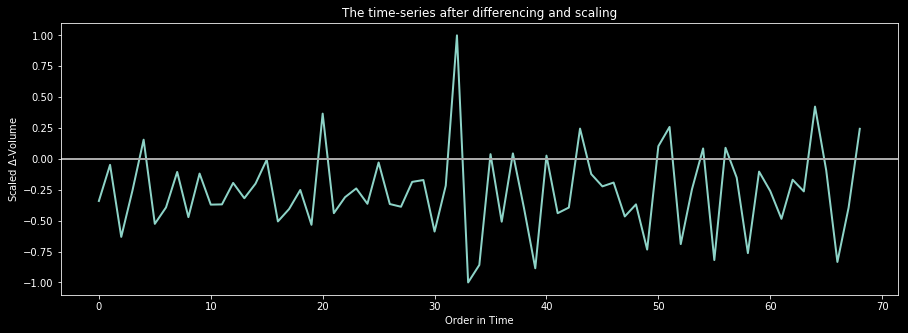

In [10]:
plt.style.use(['dark_background'])
plt.figure(figsize=[15,5])
plt.plot(trainy);
plt.axhline(y=0, color='darkgray')
plt.xlabel('Order in Time' );
plt.ylabel('Scaled $\Delta$-Volume' );
plt.title('The time-series after differencing and scaling');



## Design the LSTM <a name="design"></a>

We will use the [Keras](https://keras.io/) [Chollet, 2015.] library to design our Neural Net (NN). 

* The `Sequential()` model allows us to organize the layers of our NN.
* We can add another linear layer using `.add()`. 
    * We elect to add an `LSTM()` layer, where we specify hyperparameters such the number `neurons` or units to have in the hidden layer, or the `batch size` with which to update the model, the $\tanh$ `activation` function, etc.
* We add a final `Dense()` layer to ensure the neural output matches the dimensionality of our $Y$.
* With `.compile()`, we want to specify which `loss function` to use. We want minimize the Mean Squared Error (MSE), and in particular, we want to minimize it by using a type of Stochastic Gradient Descent variant known as [Adam](https://arxiv.org/abs/1412.6980) [Kingma, 2015].

<div style="text-align: right"> [Back to top](#toc) </div>

In [11]:
neurons = 4
batch_size = 1 

import warnings
warnings.filterwarnings('ignore')
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.LSTM(neurons, batch_input_shape=(batch_size, trainX3d.shape[1], trainX3d.shape[2]), activation='tanh', stateful=True, name='Hidden'))
model.add(layers.Dense(1, name='Final'))
model.compile(loss='mean_squared_error', optimizer='adam')
print(model.summary())

Using MXNet backend


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Hidden (LSTM)                (1, 4)                    96        
_________________________________________________________________
Final (Dense)                (1, 1)                    5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________
None




## Fit an LSTM network to training data <a name="fit"></a>

Now we are ready to train our NN model. We'll use `verbose=1` to track the behavior of the training and validation losses.

An epoch is one complete pass through the training data into the algorithm. We will use 30 passes of our training data.

**In the cell below, enter 30 as the number of epochs to use for fitting:**

<div style="text-align: right"> [Back to top](#toc) </div>

In [12]:
nb_epoch = <Enter the number of epochs:30>

In [13]:
lstm_model = model.fit(trainX3d, trainy, validation_split=0.2, epochs=nb_epoch, batch_size=batch_size, verbose=1)


Train on 55 samples, validate on 14 samples
Epoch 1/30
55/55 [==============================] - 0s 3ms/step - loss: 0.1706 - val_loss: 0.1663
Epoch 2/30
55/55 [==============================] - 0s 3ms/step - loss: 0.1336 - val_loss: 0.1427
Epoch 3/30
55/55 [==============================] - 0s 3ms/step - loss: 0.1160 - val_loss: 0.1345
Epoch 4/30
55/55 [==============================] - 0s 3ms/step - loss: 0.1093 - val_loss: 0.1306
Epoch 5/30
55/55 [==============================] - 0s 3ms/step - loss: 0.1068 - val_loss: 0.1279
Epoch 6/30
55/55 [==============================] - 0s 3ms/step - loss: 0.1065 - val_loss: 0.1292
Epoch 7/30
55/55 [==============================] - 0s 3ms/step - loss: 0.1072 - val_loss: 0.1287
Epoch 8/30
55/55 [==============================] - 0s 3ms/step - loss: 0.1053 - val_loss: 0.1272
Epoch 9/30
55/55 [==============================] - 0s 3ms/step - loss: 0.1062 - val_loss: 0.1272
Epoch 10/30
55/55 [==============================] - 0s 3ms/step - loss: 0

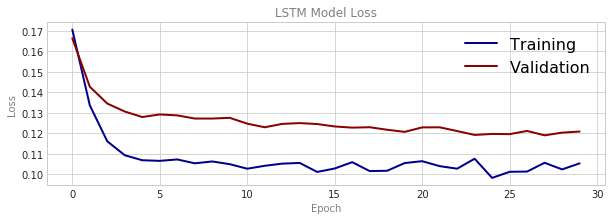

In [23]:
plt.figure(figsize=[10,3])
plt.style.use(['seaborn-whitegrid'])
plt.plot(lstm_model.history['loss'], label='Training', color='darkblue')
plt.plot(lstm_model.history['val_loss'], label='Validation', color='darkred')
plt.title('LSTM Model Loss', color='gray')
plt.ylabel('Loss', color='gray')
plt.xlabel('Epoch', color='gray')
l = plt.legend(fontsize=16)
for text in l.get_texts():
    text.set_color('black')

plt.show()




## Predict the test data <a name="predict"></a>

Let's use our trained LSTM NN to predict Trading Volumes one-step-ahead, for the remaining series:
* Forecast the entire training dataset to build up state for forecasting
* Forecast the entire test dataset
* Invert the scaling 
* Revert the differencing 

Then we've arrived at our predictions in their proper units.


<div style="text-align: right"> [Back to top](#toc) </div>

In [15]:
model.predict(trainX3d, batch_size=batch_size)
predictions_scaled = model.predict(testX3d, batch_size=1)

predictions_unscaled = scaler.inverse_transform(np.matlib.repmat(predictions_scaled, 1, train.shape[1]))[:,-1]
predictions = raw_values[train_size:-1] + predictions_unscaled

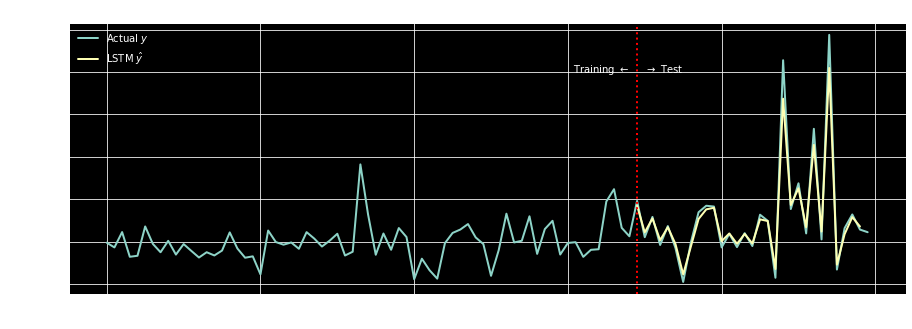

In [29]:
plt.figure(figsize=[15,5])
plt.style.use(['dark_background'])
plt.plot(raw_values, label=r'Actual $y$')
plt.plot(np.arange(train_size, n_obs), predictions, label=r'LSTM $\hat{y}$')
plt.axvline(x=train_size, color='red', linestyle=':')
plt.text(train_size-1, 2500000, r'Training $\leftarrow$', horizontalalignment='right')
plt.text(train_size+1, 2500000, r'$\rightarrow$ Test', horizontalalignment='left')
plt.xlabel('Order in Time' );
plt.ylabel('Trade Volume' );
plt.title('Forecasting Trading Volumes with an LSTM NN');
plt.legend()
plt.show()

## Evaluation the LSTM performance <a name="evaluate"></a>

The Root-Mean-Squared Error (RMSE) allows us to compare accurate our forecasts were to the actual traded volumes. The lower the RMSE, the better - a value of 0 would indicate a perfect fit to the data. 

[//]: $$ \rm{RMSE} = \sqrt {\frac {\sum _{t=1}^T(\hat{y}_t-y_t)^2}{T}} $$

RMSE is dependent on the scale of the data being used. Dividing the RMSE by the range of the data, gives an average error as a proportion of the data's scale. This is called the **Normalized Root-Mean-Squared Error** (NRMSE).

[//]: $$ \mathrm{NRMSE} = \frac{\mathrm{RMSE}}{y_\max -y_\min} $$

However, the RMSE and NRMSE are very sensitive to outliers. A robust version is the **Normalized Median Absolute Deviation** (NMAD).

[//]: $$ \mathrm{NMAD} = \frac{\rm{median}|\hat{y}_t-y_t|}{y_\max -y_\min} $$

<div style="text-align: right"> [Back to top](#toc) </div>

In [17]:
from sklearn.metrics import mean_squared_error, median_absolute_error

rmse = np.sqrt(mean_squared_error(raw_values[-test_size:], predictions))
mad = median_absolute_error(raw_values[-test_size:], predictions)
ymax = raw_values[-test_size:].max()
ymin = raw_values[-test_size:].min()
nrmse = rmse/(ymax - ymin)*100
nmad = mad/(ymax - ymin)*100

print('Normalized Root-Mean-Squared Error: %2.1f%%' %nrmse)
print('Normalized Median Absolute Deviation: %2.1f%%' %nmad)

Normalized Root-Mean-Squared Error: 30.5%
Normalized Median Absolute Deviation: 11.2%


In [19]:
whole_end = time.time()
print('Whole notebook elapsed time:', whole_end-whole_start)

Whole notebook elapsed time: 148.66741251945496


# Thank you
<div style="text-align: right"> END. OF. LAB. </div>